Author: Cristian F. Zapata 

Email: cfzapatag@uqvirtual.edu.co

Description: .......................

In [11]:
weights1=[[ 0.0382464 ,  0.7007964 ,  0.48883402, -1.4597399 , -0.05494226,
         0.02989713, -0.4351087 , -0.83853036, -1.5202916 , -1.1002505 ,
        -0.5505442 ,  1.3871921 , -0.07135123, -0.37960586, -0.91088355,
        -1.4869422 , -0.09877264, -0.388355  ],
       [-0.1829896 ,  1.0915402 , -0.0931328 , -1.6285093 ,  0.04266393,
         0.05229457, -0.77914244, -0.6778213 , -0.9977015 , -0.75988305,
        -0.6001632 , -0.30420908, -0.00931712, -0.01251281, -0.3093374 ,
         0.593511  , -0.05932434, -0.53650594],
       [ 0.14480498,  1.4691616 , -2.1929843 , -0.24474955,  0.06582585,
         0.02201997, -2.477648  , -0.26122507,  1.2176931 , -1.1311307 ,
        -0.08437473,  0.24662016, -0.1937362 ,  0.01588753, -1.586603  ,
        -1.060965  ,  0.5447839 , -0.23800962],
       [ 0.78240883,  0.6617364 ,  0.35716504, -0.39312753, -0.05788128,
         0.04223924, -1.5120978 , -0.46963078, -0.14160708, -0.501912  ,
         0.2346194 , -0.5256772 , -0.09837893, -0.20688301, -1.0432016 ,
        -0.56514215, -0.73255396,  0.41489732]]
weights1=tf.constant(weights1)
weights2=2*weights1

## Circuit

In [38]:
import numpy as np
import os
import strawberryfields as sf
from strawberryfields import ops
import tensorflow as tf
import warnings
from itertools import combinations
warnings.filterwarnings("ignore")
physical_devices = tf.config.experimental.list_physical_devices('CPU')
tf.config.experimental.set_visible_devices(physical_devices[0])

cutoff_dim = 3
modes = 4

def input_qnn_layer(hid1, hid2, q):
    """
    Applies an input layer to a quantum neural network.

    This function introduces data to the QNN by applying a sequence
    of quantum gates to the input qumode.

    Args:
        hid (list): List of a parameter for the quantum gates in the input layer.

    Returns:
        None
    """
    with tf.name_scope('inputlayer'):
        #Gates to encode fetures1[i]
        ops.Rgate(hid1[0]) | q[0]
        ops.Dgate(hid1[0]) | q[0]       
        ops.Rgate(hid1[0]) | q[0]
        
        ops.Rgate(hid1[0]) | q[1]
        ops.Dgate(hid1[0]) | q[1]       
        ops.Rgate(hid1[0]) | q[1]

        #Gate to encode feture2[i]

        ops.Rgate(hid2[0]) | q[2]
        ops.Dgate(hid2[0]) | q[2]       
        ops.Rgate(hid2[0]) | q[2]
        
        ops.Rgate(hid2[0]) | q[3]
        ops.Dgate(hid2[0]) | q[3]       
        ops.Rgate(hid2[0]) | q[3]

# Defining standard variational layers
def qnn_layer(params1,params2,layer_number,q):
    with tf.name_scope('layer_{}'.format(layer_number)):
        N = int(len(q)/2) #1/2 is for the two features
        M = int(modes/2 * (modes/2 - 1)) 
        
        #For features1 _1
        int1_1 = params1[:M]
        r1_1=params1[M:M+N]
        sm_1 = params1[M+N:M+2*N]
        sp_1 = params1[M+2*N:M+3*N]
        int2_1 = params1[M+3*N:2*M+3*N]
        r2_1=params1[2*M+3*N:2*M+4*N]
        dr_1 = params1[2*M+4*N:2*M+5*N]
        dp_1 = params1[2*M+5*N:2*M+6*N]
        ker_1 = params1[2*M+6*N:2*M+7*N]
        
        theta1_1=int1_1[:len(int1_1)//2]
        phi1_1=int1_1[len(int1_1)//2:]
        
        theta2_1=int2_1[:len(int2_1)//2]
        phi2_1=int2_1[len(int2_1)//2:]
        
        # "q[:2]" features 1 n 2 should not be entangled
        for k, (q1, q2) in enumerate(combinations(q[:2],2)):
            ops.BSgate(theta1_1[k], phi1_1[k]) | (q1, q2)
        for i in range(N):
            ops.Rgate(r1_1[i]) | q[i]
        for i in range(N):
            ops.Sgate(sm_1[i],sp_1[i]) | q[i]
        for k, (q1, q2) in enumerate(combinations(q[:2],2)):
            ops.BSgate(theta2_1[k], phi2_1[k]) | (q1, q2)
        for i in range(N):
            ops.Rgate(r2_1[i]) | q[i]
        for i in range(N):
            ops.Dgate(dr_1[i], dp_1[i]) | q[i]
        for i in range(N):
            ops.Kgate(ker_1[i]) | q[i]
        
        #for features2 _2

        int1_2 = params2[:M]
        r1_2=params2[M:M+N]
        sm_2 = params2[M+N:M+2*N]
        sp_2 = params2[M+2*N:M+3*N]
        int2_2 = params2[M+3*N:2*M+3*N]
        r2_2=params2[2*M+3*N:2*M+4*N]
        dr_2 = params2[2*M+4*N:2*M+5*N]
        dp_2 = params2[2*M+5*N:2*M+6*N]
        ker_2 = params2[2*M+6*N:2*M+7*N]
        
        theta1_2=int1_2[:len(int1_2)//2]
        phi1_2=int1_2[len(int1_2)//2:]
        
        theta2_2=int2_2[:len(int2_2)//2]
        phi2_2=int2_2[len(int2_2)//2:]
        
        # "q[2:]" features 1 n 2 should not be entangled
        for k, (q1, q2) in enumerate(combinations(q[2:],2)):
            ops.BSgate(theta1_2[k], phi1_2[k]) | (q1, q2)
        for i in range(N):
            ops.Rgate(r1_2[i]) | q[i]
        for i in range(N):
            ops.Sgate(sm_2[i],sp_2[i]) | q[i]
        for k, (q1, q2) in enumerate(combinations(q[2:],2)):
            ops.BSgate(theta2_2[k], phi2_2[k]) | (q1, q2)
        for i in range(N):
            ops.Rgate(r2_2[i]) | q[i]
        for i in range(N):
            ops.Dgate(dr_2[i], dp_2[i]) | q[i]
        for i in range(N):
            ops.Kgate(ker_2[i]) | q[i]


layers=4
hidden_units=3*modes 

eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
qnn = sf.Program(modes)
num_params = np.prod(weights1.shape)
  

sf_params1 = np.arange(num_params).reshape(weights1.shape).astype(str)
sf_params1 = np.array([qnn.params(*i) for i in sf_params1])

hid_params1 = np.arange(num_params,num_params+hidden_units).reshape(hidden_units,1).astype(str)
hid_params1 = np.array([qnn.params(*i) for i in hid_params1])

#to introduce trained weights of features1
sf_params2 = np.arange(num_params+hidden_units, 2*num_params+hidden_units ).reshape(weights2.shape).astype(str) 
sf_params2 = np.array([qnn.params(*i) for i in sf_params2])

hid_params2 = np.arange(2*num_params+hidden_units,2*num_params + 2*hidden_units).reshape(hidden_units,1).astype(str)
hid_params2 = np.array([qnn.params(*i) for i in hid_params2])


with qnn.context as q:
    input_qnn_layer(hid_params1,hid_params2,q)
    for k in range(layers):
        qnn_layer( sf_params1[k] , sf_params2[k] , k , q  )

In [43]:
mapping_wt = {p.name: w for p, w in zip( sf_params1.flatten() , tf.reshape(weights1, [-1]))}
mapping_hid={p.name: w for p, w in zip(hid_params1, tf.fill((6,), 1) )}
mapping_wt2 = {p.name: w for p, w in zip( sf_params2.flatten() , tf.reshape(weights2, [-1]))}
mapping_hid2={p.name: w for p, w in zip(hid_params2, tf.fill((6,), 2) )}
mapping_wt.update(mapping_hid)
mapping_wt.update(mapping_wt2)
mapping_wt.update(mapping_hid2)
mapping_wt

{'0': <tf.Tensor: shape=(), dtype=float32, numpy=0.0382464>,
 '1': <tf.Tensor: shape=(), dtype=float32, numpy=0.7007964>,
 '2': <tf.Tensor: shape=(), dtype=float32, numpy=0.48883402>,
 '3': <tf.Tensor: shape=(), dtype=float32, numpy=-1.4597399>,
 '4': <tf.Tensor: shape=(), dtype=float32, numpy=-0.05494226>,
 '5': <tf.Tensor: shape=(), dtype=float32, numpy=0.02989713>,
 '6': <tf.Tensor: shape=(), dtype=float32, numpy=-0.4351087>,
 '7': <tf.Tensor: shape=(), dtype=float32, numpy=-0.83853036>,
 '8': <tf.Tensor: shape=(), dtype=float32, numpy=-1.5202916>,
 '9': <tf.Tensor: shape=(), dtype=float32, numpy=-1.1002505>,
 '10': <tf.Tensor: shape=(), dtype=float32, numpy=-0.5505442>,
 '11': <tf.Tensor: shape=(), dtype=float32, numpy=1.3871921>,
 '12': <tf.Tensor: shape=(), dtype=float32, numpy=-0.07135123>,
 '13': <tf.Tensor: shape=(), dtype=float32, numpy=-0.37960586>,
 '14': <tf.Tensor: shape=(), dtype=float32, numpy=-0.91088355>,
 '15': <tf.Tensor: shape=(), dtype=float32, numpy=-1.4869422>,


In [45]:
weights2

<tf.Tensor: shape=(4, 18), dtype=float32, numpy=
array([[ 0.0764928 ,  1.4015929 ,  0.97766805, -2.9194798 , -0.10988452,
         0.05979426, -0.8702174 , -1.6770607 , -3.0405831 , -2.200501  ,
        -1.1010884 ,  2.7743843 , -0.14270246, -0.7592117 , -1.8217671 ,
        -2.9738843 , -0.19754528, -0.77671   ],
       [-0.3659792 ,  2.1830804 , -0.1862656 , -3.2570186 ,  0.08532786,
         0.10458914, -1.5582849 , -1.3556426 , -1.995403  , -1.5197661 ,
        -1.2003264 , -0.60841817, -0.01863424, -0.02502562, -0.6186748 ,
         1.187022  , -0.11864868, -1.0730119 ],
       [ 0.28960997,  2.9383233 , -4.3859687 , -0.4894991 ,  0.1316517 ,
         0.04403994, -4.955296  , -0.52245015,  2.4353862 , -2.2622614 ,
        -0.16874947,  0.49324033, -0.3874724 ,  0.03177506, -3.173206  ,
        -2.12193   ,  1.0895678 , -0.47601923],
       [ 1.5648177 ,  1.3234729 ,  0.7143301 , -0.78625506, -0.11576256,
         0.08447848, -3.0241957 , -0.93926156, -0.28321415, -1.003824  ,
    

## VQMF

In [49]:
def state_VQFM(x1, x2):
    """make vqfm of a data, putting it as a parameter in the encoding layer"""
    """
    Generates a Quantum State using a Variational QFM (VQFM) encoding layer.

    This function takes input data 'x' and evaluate the quantum state by mapping it through
    a Variational circuit.

    Args:
        x (float): Input data to be encoded in the quantum state.

    Returns:
        tf.Tensor: Quantum state represented as a complex-valued tensor.
    """
    mapping_wt = {p.name: w for p, w in zip( sf_params1.flatten() , tf.reshape(weights1, [-1]))}
    mapping_hid={p.name: w for p, w in zip(hid_params1, tf.fill((6,), x1) )}
    mapping_wt2 = {p.name: w for p, w in zip( sf_params2.flatten() , tf.reshape(weights2, [-1]))}
    mapping_hid2={p.name: w for p, w in zip(hid_params2, tf.fill((6,), x2) )}
    mapping_wt.update(mapping_hid)
    mapping_wt.update(mapping_wt2)
    mapping_wt.update(mapping_hid2)
    results = eng.run(qnn, args=mapping_wt)
    ket = results.state.ket()
    ket=tf.reshape(ket, [-1])
    ket=tf.cast(ket, tf.complex128)
    if eng.run_progs:
        eng.reset()
    return ket 

In [50]:
state_VQFM(0.33, 1)

<tf.Tensor: shape=(81,), dtype=complex128, numpy=
array([ 1.98171526e-01-7.25324154e-02j, -4.39919755e-02-3.97361629e-02j,
       -2.90532340e-03+1.14114666e-02j,  3.86519432e-02-2.89926827e-01j,
       -7.71053880e-02+2.83892192e-02j, -4.95407581e-02+1.26508400e-02j,
       -2.33984530e-01-1.65611446e-01j,  2.73545110e-03+6.18013879e-03j,
        6.17021171e-04+3.43148306e-04j, -1.48334265e-01+1.73127055e-02j,
        2.37402115e-02+3.45889777e-02j,  3.87750869e-03-7.37629551e-03j,
       -7.43127614e-02+1.93192050e-01j,  5.77421635e-02-6.85170665e-03j,
        3.61799747e-02-5.55142760e-04j,  1.33795872e-01+1.52491584e-01j,
       -8.65780283e-04-4.70382953e-03j, -3.68219538e-04-3.37718608e-04j,
       -7.67305680e-03+1.53272331e-01j,  3.90902422e-02-1.81789454e-02j,
       -6.81625213e-03-5.18367719e-03j,  1.83155969e-01+1.08157076e-01j,
        2.87297275e-03-5.96835390e-02j,  5.58840577e-03-3.67609039e-02j,
        1.77289128e-01-1.09669708e-01j, -4.91429027e-03+7.77142704e-05j,
 

## Wigner plots
Visualize the Wigner plots

In [123]:
#density matrix
rho_target = np.outer(QFM1, QFM1.conj())
rho_learnt = np.outer(ket, ket.conj())

In [124]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Target

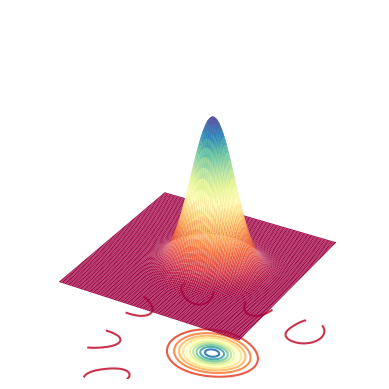

In [125]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.1)
ax.set_axis_off()
plt.savefig("T.png")
fig.show()

Learn

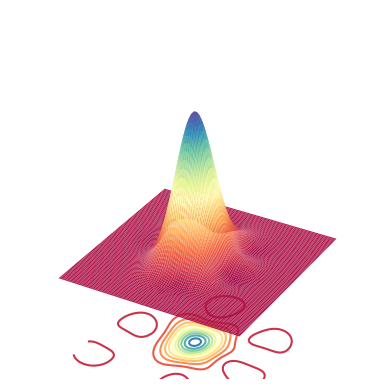

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.1) #0.2
ax.set_axis_off()
plt.savefig("L.png")
fig.show()

In [127]:
#Training state
ket

array([ 9.82110381e-01+0.01120844j, -1.54363900e-01+0.00837617j,
       -5.02181649e-02-0.00851939j,  1.91736370e-02+0.02703849j,
       -3.06018516e-02-0.02445906j,  2.56862789e-02+0.01090356j,
        1.23697603e-02+0.02752953j,  4.60684911e-04-0.00167919j,
       -1.15053292e-04-0.00399283j])

In [128]:
#Quantum features map
QFM1

array([[9.41710616e-01+0.00000000e+00j, 3.07719176e-01-7.53694609e-17j,
        1.23150814e-01-6.03265000e-17j, 5.19515795e-02-3.81734013e-17j,
        2.24571622e-02-2.20016735e-17j, 9.84528344e-03-1.20569949e-17j,
        4.35598160e-03-6.40144671e-18j, 1.93975012e-03-3.32571229e-18j,
        8.67927640e-04-1.70064769e-18j]])